In [318]:
%matplotlib inline
import numpy as np
from scipy.stats import norm,uniform,lognorm
import matplotlib.pyplot as plt
import seaborn as sbn
import pandas as pd
import pymc3 as pm3

np.random.seed(348348756)

plt.style.use('ggplot')

In [319]:
data = pd.read_csv("MLBData.csv")

# Bayesian Analysis of MLB Data
Owen Fish
5/8/2019

### Introduction
An important piece of information when evaluating a team's chance of success in any sport is strength of schedule. In NFL Football, it is not uncommon to see large changes in win percentage across years due to relative schedule difficulty. This result is not surprising; of course the same team will be more successful against relatively weak opponents. However, in sports like baseball or basketball, it does not play a large factor. This is because of the amount of games played in baseball or basketball compared to football. Schedules in Major League Baseball are largely similar from year-to-year, while schedules in football change drastically. Another important relationship to consider when predicting team success is strength teams with whom you are competing for spots. It is clear that in baseball or basketball different teams are the beneficiaries of easier circumstances, while others struggle due to rising league polarity. For example, in 2018, the Denver Nuggets missed the NBA Western Conference Playoffs after only accumulating 46 wins. In the Eastern Conference, however, the Miami Heat, Milwaukee Bucks, and Washington Wizards all made the playoffs with 44, 44, and 43 wins respectively. If the Denver Nuggets were in the Eastern Conference, their record would have secured them the 6th seed. This happens in Major League Baseball as well, as it will in any sport who's playoff system is not simply a collection of the n best teams regardless of league or division. It is not the purpose of this research to speak about the effectiveness of the given playoff tiering system; after all, the theoretical purpose of Major League Baseball is to generate revenue, not necessarily to play baseball. Rather, we seek to use the given relationships to more effectively determine the strength of two factors needed for inclusion in that system.

Currently, virtually any prediction into MLB Playoff Prediction, such as those widgtets found on MLB.com or on statistical blogs, acts roughly the same way. Each prediction relies heavily on a team strength measurement, which is used to simulate the rest of the season for each team. Then, the probability of making the playoffs is the normalized frequency of occurrence over multiple simulations. This model, though often effective, does not tell a full story. For one, this type of analysis does not gather any data about the differences between the leagues, though we still see scenarios like the one outlined above. We attempt to explore this difference in distributions of the problem parameters to help get an idea of "playoff probability elasticity" to help teams efficiently spend resources. 


### Literature Review
The presence of a designated hitter was first introduced to the American League in 1973. Virtually since it's deployment, the average runs per game for DH-enabled teams has been greater than the average runs per game for non-DH enabled teams (Cooley, 2010). The presence of the Designated Hitter has also improved the pitching for DH-enabled teams (Cooley, 2010). This is likely due to the extra focus that marquee pitchers on American League clubs can put to pitching. At the time of the introduction of the DH, it was also hypothesized that the number of complete games thrown by American League teams should be greater than that of National League teams for that very reason. However, we saw a reduction in the number of complete games after the introduction of the DH, but likely due to the coincidence that around that same time specialized pitchers became much more common. The exact impact of the designated hitter is difficult to measure, especially in terms of comparing AL teams to NL teams. How much of the difference in mean runs per game can be attributed to the presence of the designated hitter and how much is simply error or polarization?  

### Data

Like is the case in most sports, there are two aspects to baseball: offense and defense. In baseball, however, these two aspects are remarkably distinct and independent. There is virtually nothing that a team can do on the offensive end that will influence what it does on the defensive end. This property is useful in that it compartmentalizes potential changes and potential effects nicely. While offense and defense could be modeled in the multivariate case, we choose to take a more direct measurement of offensive and defensive prowess: Runs scored per game and Runs allowed per game. 

Our data was gathered from baseball-reference.com and contains 240 observations of 5 variables <br>

|Tm|Team|
|--|----|
|R/G| Runs per game|
|RA/G| Runs against per game|
|Playoffs| Binary variable if that team made the playoffs|
|Year| Year of observation|

We chose 240 observations as our amount because it stretches back through the 2011 MLB Season. Before this year, the playoff format was slightly different than it is now (Each league had only one wild-card team, whereas now each has two). 

In [412]:
data.head(10)

,Tm,R/G,RA/G,Playoffs,Year,AL
0,ARI,4.28,3.98,0,2018,0
1,ATL,4.69,4.06,1,2018,0
2,BAL,3.84,5.51,0,2018,1
3,BOS,5.41,3.99,1,2018,1
4,CHC,4.67,3.96,1,2018,0
5,CHW,4.05,5.23,0,2018,1
6,CIN,4.30,5.06,0,2018,0
7,CLE,5.05,4.00,1,2018,1
8,COL,4.79,4.57,1,2018,0
9,DET,3.89,4.91,0,2018,1


Note that this dataset does not include league as a covariate. We want to add that in before we do anything else. The following code does that. 

In [413]:
AL = {"BOS", "NYY", "BAL", "TOR", "TBR", "CLE", "MIN", "DET", "CHW", "KCR", "HOU", "SEA", "TEX", "LAA", "OAK"}
NL = {"STL", "CHC", "MIL", "PIT", "CIN", "ARI", "LAD", "SDP", "COL", "SFG", "ATL", "WSN", "PHI", "MIA", "NYM"}

leagueDict = {}
for team in AL:
    leagueDict[team] = "AL"
for team in NL:
    leagueDict[team] = 'NL'
    
data["AL"] = pd.Series(map(lambda x: int(leagueDict[x] == "AL"), data['Tm']))

In [414]:
data.head(10)

,Tm,R/G,RA/G,Playoffs,Year,AL
0,ARI,4.28,3.98,0,2018,0
1,ATL,4.69,4.06,1,2018,0
2,BAL,3.84,5.51,0,2018,1
3,BOS,5.41,3.99,1,2018,1
4,CHC,4.67,3.96,1,2018,0
5,CHW,4.05,5.23,0,2018,1
6,CIN,4.30,5.06,0,2018,0
7,CLE,5.05,4.00,1,2018,1
8,COL,4.79,4.57,1,2018,0
9,DET,3.89,4.91,0,2018,1


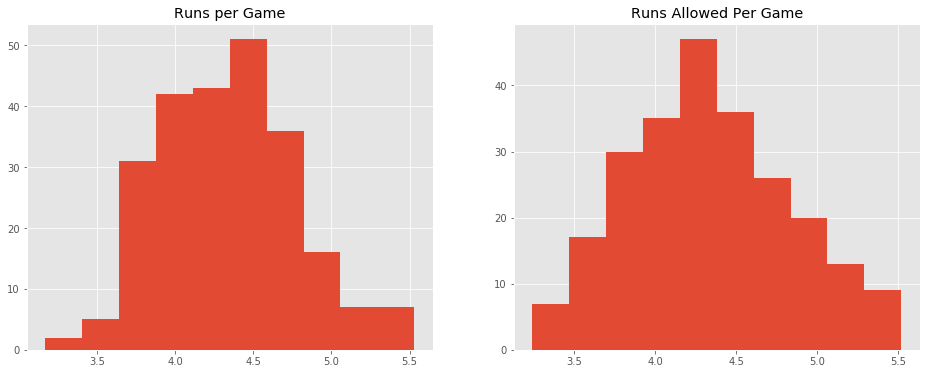

In [415]:
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.hist(data["R/G"])
plt.title("Runs per Game")

plt.subplot(1,2,2)
plt.hist(data['RA/G'])
plt.title("Runs Allowed Per Game")
plt.show()

By definition, the total number of runs scored equals the total numbers of runs allowed, so the expectation of R/G must equal that of RA/G. We verify that here.

In [416]:
print("E[R/G]  = " + str(np.mean(data['R/G'])))
print("E[RA/G] = " + str(np.mean(data['RA/G'])))

E[R/G]  = 4.332958333333331
E[RA/G] = 4.332749999999998


This is not perfect, but the small amount of variation is due to rounding error in the measurements of runs per game and runs allowed per game. <br>

It is important to note, however, that just because the expected values are equal by definition, R/G and RA/G are not necessarily identically distributed. 

## Correlation
Before we fit a model to this data, we want to show that the covariates are not correlated. Because of the nature of baseball, as outlined above, we do not expect offensive and defensive skill to be correlated, but we wish to verify this assumption before continuing. 

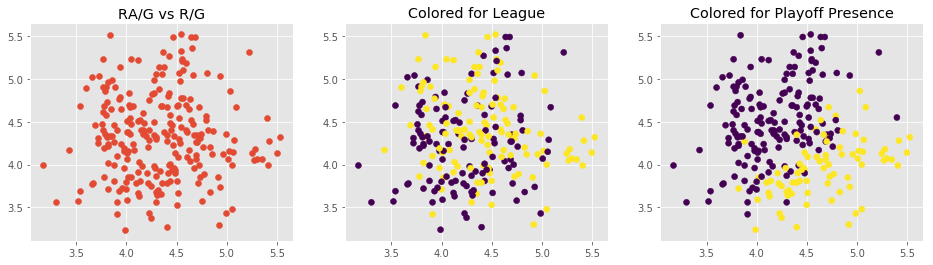

In [328]:
plt.figure(figsize=(16,4))

plt.subplot(1,3,1)
plt.scatter(data["R/G"], data["RA/G"])
plt.axes
plt.title("RA/G vs R/G")

plt.subplot(1,3,2)
plt.scatter(data["R/G"], data["RA/G"], c=data['AL'])
plt.title("Colored for League")

plt.subplot(1,3,3)
plt.title("Colored for Playoff Presence")
plt.scatter(data['R/G'], data['RA/G'], c=data['Playoffs'])
plt.show()

We do not see any correlation between the covariates Runs per game and Runs allowed per game either across the entire MLB or across each League. We do see correlation between the vector $(R/G, RA/G)_i$ and $Playoff_i$, which is expected and good. If these variables did not seem to be correlated, than a model with these covariates would not be appropriate.   

# 1. Logit Model
We first create baseball_logit, a logistic regression model that models $playoffs = \beta_0 + \beta_1 * R/G + \beta_2 * RA/G$ 

In [297]:
with pm3.Model() as baseball_logit:
    beta0 = pm3.Flat("Intercept")
    beta1 = pm3.Flat("Effects of Runs per Game")
    beta2 = pm3.Flat("Effects of Runs Allowed per Game")
    
    mu = beta0 + beta1 * data['R/G'] + beta2 * data['RA/G']
    
    def logistic_cdf(x):
        import theano.tensor as t
        return t.exp(x) / (1 + t.exp(x)) 
    
    prob=logistic_cdf(mu)
    like = pm3.Bernoulli("Playoffs", p=prob, observed = data['Playoffs'] )

In [298]:
with baseball_logit:
    step = pm3.NUTS()
    trace_1 = pm3.sample(5000, progressbar=True, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Effects of Runs Allowed per Game, Effects of Runs per Game, Intercept]
Sampling 4 chains: 100%|██████████| 24000/24000 [00:43<00:00, 553.53draws/s]
The acceptance probability does not match the target. It is 0.882320427545365, but should be close to 0.8. Try to increase the number of tuning steps.


In [346]:
pm3.summary(trace_1)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
Intercept,-2.809556,3.327217,0.035944,-9.414538,3.601064,8538.068488,1.000122
Effects of Runs per Game,6.448977,0.999452,0.011792,4.582045,8.437861,6948.469371,1.000117
Effects of Runs Allowed per Game,-6.309057,0.959717,0.009704,-8.251389,-4.554539,7425.973505,1.000081


The summary of this model implies that the benefits of scoring an extra run are roughly equal to the downsides of giving up an extra run per game in terms of playoff probabilities. With this model, a team that scores 4 runs per game and gives up 4 runs per game has a postseason inclusion probability of 
$$\frac{1}{1 + e^{-(-2.8 + 6.44\cdot 4 - 6.309 \cdot 4)}} = 0.09$$ while a team who scores 5 runs per game and gives up 3 has a postseason inclusion probability of $$\frac{1}{1 + e^{-(-2.8 + 6.44\cdot 5 - 6.309 \cdot 3)}} = 0.9999$$
These probabilities seem to be consistent with the 2-Dimensional colored chart from above that shows each team as a (x,y) coordinate and colored for whether or not that team made the playoffs.

In [312]:
al_idx = data["AL"].values
count_means = data['AL'].value_counts()

# Hierarchical Logit Model

We create baseball_logit, a logistic regression model that models $playoffs = \beta_0 + \beta_1 * R/G + \beta_2 * RA/G$ with hierarchical parameters $\beta_0, \beta_1, \beta_2$ that differ across League - American vs National. 

This type of hierarchical parameterization is necessary in this case for two reasons. First, and most importantly, the American League supports the use of the designated hitter while the National League does not. It is not unreasonable to say that the presence of the DH inflates runs among American League teams, thus runs among AL teams are likely to not be valued as highly as they are in the National League. By the same logic, defensive value could be different across the leagues for the reason of the DH. Second, it is very possible that league polarization has occurred, and there is a strength discrepancy in one league vs the other. These reasons lead us to fit a Logistic Model with hierarchical parameters across the two leagues within the MLB.

We do not assume any knowledge about the parent distributions, but we assume that each of the $\beta$ parameters is normally distributed. We do not assume any knowledge about the intercept distribution. That gives us the following formulation:

$$\mu_{\beta_1}, \mu_{\beta_2} \sim Uniform() \\
  \sigma_{\beta_1}, \sigma_{\beta_2} \sim HalfNormal()\\
$$
$$ \beta_1^{NL}, \beta_1^{AL} \sim Normal(\mu_{\beta_1}, \sigma_{\beta_1})\\
   \beta_2^{NL}, \beta_2^{AL} \sim Normal(\mu_{\beta_2}, \sigma_{\beta_2}) $$

In [400]:
with pm3.Model() as hier_baseball_logit:
    
    #Parent Distributions
    mu_beta_1 = pm3.Flat("Mean Effects of Runs Per Game")
    sigma_1 = pm3.HalfNormal("Beta 1 S.D")
    mu_beta_2 = pm3.Flat("Mean Effects of Runs Allowed Per Game")
    sigma_2 = pm3.HalfNormal("Beta 2 S.D")
    
    #Heirarchical Children parameters
    beta_1 = pm3.Normal("Effects of Runs Per Game by League", mu=mu_beta_1, sd=sigma_1, shape=2)
    beta_2 = pm3.Normal("Effects of Runs Allowed Per Game by League", mu=mu_beta_2, sd=sigma_2, shape=2)
    intercept_league = pm3.Flat("Intercept", shape=2)
    
    mu = intercept_league[al_idx] + beta_1[al_idx]*data['R/G'] + beta_2[al_idx]*data['RA/G']
    
    def logistic_cdf(x):
        import theano.tensor as t
        return t.exp(x) / (1 + t.exp(x))
    
    prob = logistic_cdf(mu)
    
    #likelihood
    like = pm3.Bernoulli('Playoffs', p=prob, observed=data['Playoffs'])

In [389]:
with hier_baseball_logit:
    step = pm3.NUTS()
    trace_2 = pm3.sample(10000, progressbar=True, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, Effects of Runs Allowed Per Game by League, Effects of Runs Per Game by League, Beta 2 S.D, Mean Effects of Runs Allowed Per Game, Beta 1 S.D, Mean Effects of Runs Per Game]
Sampling 4 chains: 100%|██████████| 44000/44000 [02:27<00:00, 298.77draws/s]
There were 249 divergences after tuning. Increase `target_accept` or reparameterize.
There were 306 divergences after tuning. Increase `target_accept` or reparameterize.
There were 195 divergences after tuning. Increase `target_accept` or reparameterize.
There were 194 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


# Results

## 1. Convergence
    The Hierarchical model that we ran did not always converge. Divergences in our sample introduce bias into our parameter distributions because we are essentially including chain values of infinity. To attempt to counteract this, we ran another model using a random offset parameter $\sim Normal(0, \sigma)$ and added it to the parent distribution, rather than drawing from the parent distribution.    

In [ ]:
with pm3.Model() as hier_baseball_logit_2:
    
    #Parent Distributions
    mu_beta_1 = pm3.Flat("Mean Effects of Runs Per Game")
    sigma_1 = pm3.HalfNormal("Beta 1 S.D")
    mu_beta_2 = pm3.Flat("Mean Effects of Runs Allowed Per Game")
    sigma_2 = pm3.HalfNormal("Beta 2 S.D")
    
    #Heirarchical Children parameters
    beta_1_offset = pm3.Normal("B1 Offset", mu=0, sd=1, shape=2)
    beta_2_offset = pm3.Normal("B2 Offset", mu=0, sd=1, shape=2)
    beta_1 = pm3.Deterministic("Effects of runs per game", mu_beta_1 + beta_1_offset * sigma_1)
    beta_2 = pm3.Deterministic("Effects of Runs Allowed Per Game", mu_beta_2 + beta_2_offset*sigma_2)
    intercept_league = pm3.Flat("Intercept", shape=2)
    
    mu = intercept_league[al_idx] + beta_1[al_idx]*data['R/G'] + beta_2[al_idx]*data['RA/G']
    
    def logistic_cdf(x):
        import theano.tensor as t
        return t.exp(x) / (1 + t.exp(x))
    
    prob = logistic_cdf(mu)
    
    #likelihood
    like = pm3.Bernoulli('Playoffs', p=prob, observed=data['Playoffs'])

In [ ]:
with hier_baseball_logit_2:
    step = pm3.NUTS()
    trace_3 = pm3.sample(10000, progressbar=True, tune=1000)

## Model Selection

Though this reformulation of the problem did help lower the number of divergences for some chains, it greatly increased the number of divergences for some parameters. All three of the models we ran had very similar WAIC values:

In [ ]:
comp = pm3.compare({baseball_logit: trace_1, hier_baseball_logit: trace_2, hier_baseball_logit_2: trace_3})
comp

Due to the parameters of the problem we are trying to solve, we elect to use the second model: $$Playoffs_{L} = \beta_{L}^0 + \beta_{L}^1 \cdot R/G + \beta_{L}^2 \cdot RA/G$$

That model has the following trace plots

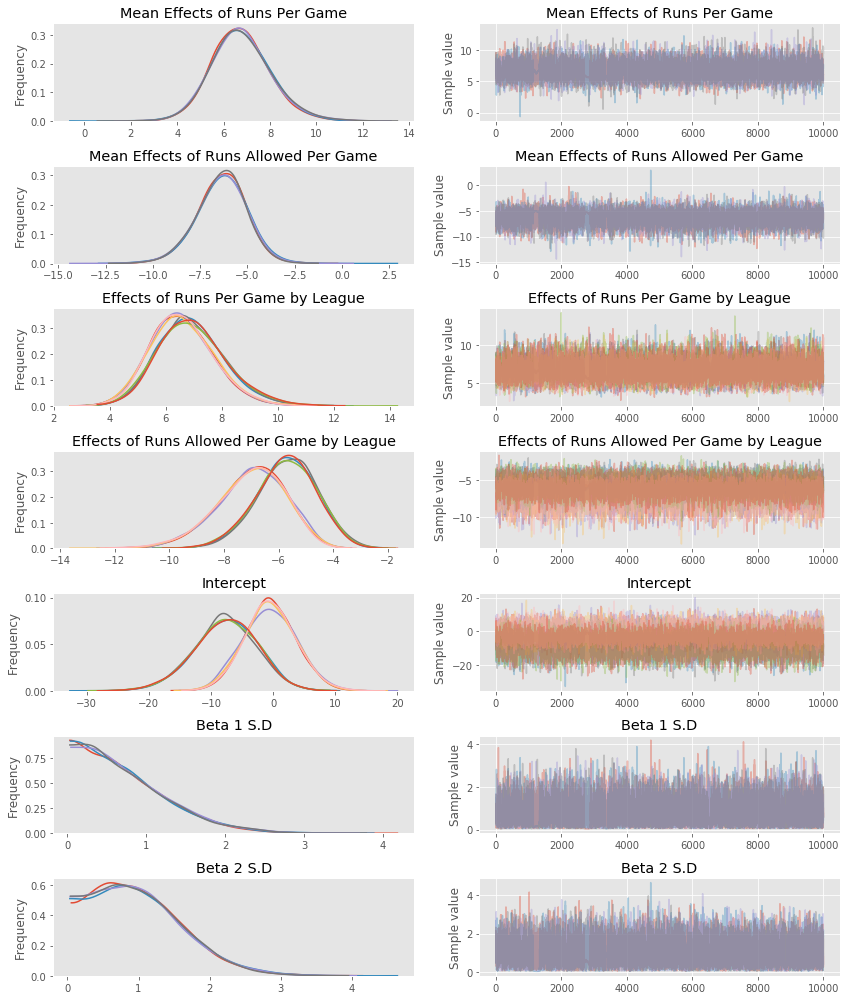

In [410]:
pm3.traceplot(trace_2)
plt.show()

The traceplots for intercept and runs allowed clearly show two distinct posterior distributions. The effects of runs scored also shows two modestly different distributions, but the difference is not as pronounced as it is in the other variables.

In [411]:
pm3.summary(trace_2)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
Mean Effects of Runs Per Game,6.753016,1.255619,0.013306,4.388851,9.344127,10908.877531,1.000163
Mean Effects of Runs Allowed Per Game,-6.352670,1.296614,0.012832,-8.944785,-3.847299,12222.366049,1.000282
Effects of Runs Per Game by League__0,6.578310,1.124799,0.012056,4.469389,8.871427,10991.431541,1.000139
Effects of Runs Per Game by League__1,6.936797,1.204373,0.012722,4.717812,9.432995,10431.212481,1.000156
Effects of Runs Allowed Per Game by League__0,-7.009955,1.264995,0.013787,-9.564429,-4.695008,8375.637538,1.000262
Effects of Runs Allowed Per Game by League__1,-5.709659,1.102291,0.010074,-7.857180,-3.549849,12575.788627,1.000656
Intercept__0,-0.463767,4.154147,0.041359,-8.595491,7.603666,10609.655342,1.000095
Intercept__1,-7.635059,5.039904,0.049562,-17.720714,1.996835,12203.159021,1.000216
Beta 1 S.D,0.758385,0.553176,0.006766,0.034058,1.824217,7247.839272,1.000182
Beta 2 S.D,0.993720,0.619438,0.006988,0.033050,2.126447,7623.781243,1.000001


Here, League 0 is the American League, and League 1 is the National League. We can clearly see that the difference in the Effect of Runs Per Game is small - 0.35 runs per game, whereas the difference in Effects of Runs Allowed Per Game is much bigger - 1.3. 

## 3. Findings

Using our model, we estimate the probability of making the playoffs to be 
$$P(Playoffs | (R/G, RA/G), L) = \frac{1}{1 + e^{-()}}$$

Thus, we estimate the relative importance of offense and defense among the American and National League to be the following:

|League|param|abs($\mu_{L}^p)$|
|------|---|-----------|
|AL|offense|6.58|
|AL|defense|7.01|
|NL|offense|6.94|
|NL|defense|5.7|

Thus, in the American League, it is more beneficial to allocate resources to improving defense, while in the National League, it is more beneficial to spend resources improving offense. That is, an AL club will greater improve its playoff inclusion probability by shaving one run allowed than it will by adding one extra run. A National League team will help itself by doing the opposite; investing in hitting will help the team more than investing in fielding will.

However, that is not to discount the role that the other aspect of the game plays in improving playoff odds. The coefficients are distributed this way, but the coefficients are not constants, and vary. 

# Conclusion

This model was meant to provide an estimate of the effect that offensive and defensive improvements has on a MLB team's playoff probabilities. By sampling from the posterior distributions of the $\beta$ parameters associated with offensive and defensive measures, we have a good idea of how each one is distributed. We asked this problem specifically because in any industry, resources are limited. In such a system, the idea of efficiency rings especially important. Having an idea for the posterior distribution of the effects of investing in a part of the game is incredibly useful in optimizing systems. However, that is not to say that this model did not have troublesome parts. 

First, the number of divergences when sampling from the posterior distribution is a little worrisome. Because the means of each league are very close to the mean from the entire MLB, I did not think that our sample was biased. That is, when we used hierarchical parameters for the effects of investments toward each aspect of the game, our new distributions seemed to be on the same scale and just "break up" the distribution of that of the entire MLB. However, given more time and resources I would reparameterize this problem to achieve zero divergences. 

Also, the interpretation of the results may lead to bad decisions about how to act. Though the hierarchical parameters are distributed as we found them, with expected values equal to those in the table above, our optimal decisions are only optimal on the average. It may very well be the case that for some team in the National League, it is optimal to invest in defense. Given more time I would try to gather more data to attempt to further separate these two distributions and lower the probability of a false positive. 

Finally, we took measurements for offensive and defensive skill as the composite of many different factors. This model could be improved by using data that includes specifics about pitching and fielding rather than just "defense." This would help us by giving us a better idea of what needs to be fixed within defense to best optimize our original problem, maximizing our probability of making the playoffs. 

# References

* Salvatier, John, Thomas V. Wiecki, and Christopher Fonnesbeck. "Probabilistic programming in Python using PyMC3." PeerJ Computer Science 2 (2016): e55.

* Cooley, Andrew. "REVISITING THE IMPACT OF THE DESIGNATED HITTER ON MAJOR LEAGUE BASEBALL." (2010).

* Kleinbaum, David G., et al. Logistic regression. New York: Springer-Verlag, 2002.

* www.baseball-reference.com

